In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns
import kinesis as kn
import gapipes as gp

In [2]:
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.dynamics.mockstream import fardal_stream, streakline_stream
from gala.dynamics import mockstream as ms

plt.style.use('smoh')
plt.rc('figure', figsize=(4,4))

In [4]:
gc_frame = coord.Galactocentric()

cl = coord.ICRS(
    x=17.154 * u.pc,
    y=41.289 * u.pc,
    z=13.691 * u.pc,
    v_x=-6.086 * u.km / u.s,
    v_y=45.629 * u.km / u.s,
    v_z=5.518 * u.km / u.s,
    representation_type="cartesian",
    differential_type="cartesian",
).transform_to(gc_frame)
w0_cl = gd.PhaseSpacePosition(cl.data)

In [35]:
print(w0_cl)

pos=(-8343.63940851, 0.3363773, 10.32250777) pc
vel=(-31.09371899, 213.05760338, 6.14587187) km / s


In [5]:
potential = gp.MilkyWayPotential()

In [32]:
orbit_backwards = potential.integrate_orbit(w0_cl, dt=-0.5*u.Myr, t2=-700*u.Myr, t1=0*u.Myr)
orbit = potential.integrate_orbit(orbit_backwards[-1], t1=-700*u.Myr, t2=100*u.Myr, dt=0.5*u.Myr)

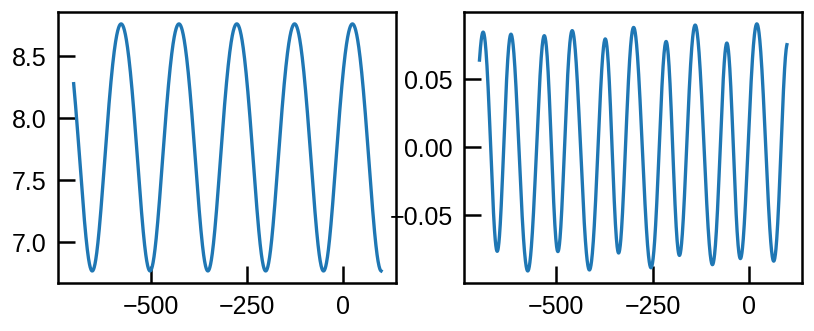

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(orbit.t, orbit.cylindrical.rho)
ax2.plot(orbit.t, orbit.cylindrical.z);

In [41]:
from astropy.visualization import quantity_support

In [44]:
gc_frame.z_sun, gc_frame.galcen_coord

(<Quantity 27. pc>, <ICRS Coordinate: (ra, dec) in deg
     (266.4051, -28.936175)>)

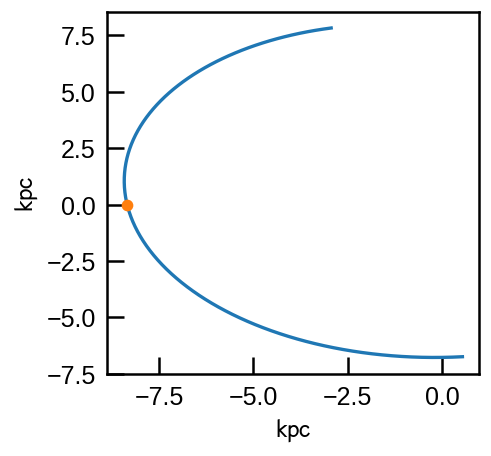

In [50]:
slc = (orbit.t>-50*u.Myr) & (orbit.t<50*u.Myr)

with quantity_support():
    fig, ax = plt.subplots()
    ax.plot(orbit[slc].x, orbit[slc].y);
    ax.plot(w0_cl.x, w0_cl.y, 'C1o')

In [54]:
df = kn.data.load_hyades_dataset().query('Member_r19 !="other"')

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [ ]:
df.g.galactic

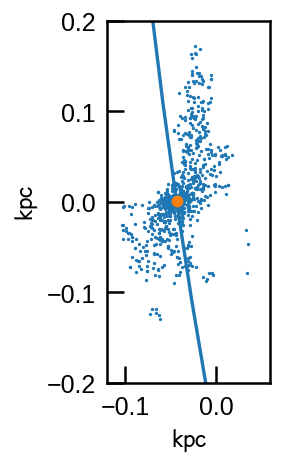

In [65]:
orbit_galactic_coord = orbit.to_coord_frame(coord.Galactic)
pos0_galactic_coord = w0_cl.to_coord_frame(coord.Galactic)

slc = (orbit.t>-10*u.Myr) & (orbit.t<10*u.Myr)

with quantity_support():
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot(orbit_galactic_coord[slc].cartesian.x, orbit_galactic_coord[slc].cartesian.y);
    ax.plot(pos0_galactic_coord.cartesian.x, pos0_galactic_coord.cartesian.y, 'C1o')
    
    ax.scatter(df.g.galactic.cartesian.x, df.g.galactic.cartesian.y, s=1);
    ax.set_ylim(-200/1e3,200/1e3)
    ax.set_xlim(-120/1e3,60/1e3)

In [72]:
(1./u.Myr**2).to(u.km**2/u.s**2/u.kpc**2)

<Quantity 956077.62876447 km2 / (kpc2 s2)>

In [76]:
M = potential.hessian(w0_cl.xyz)[:,:,0].to(u.km**2/u.s**2/u.kpc**2)
M

<Quantity [[-5.72679597e+02,  2.82779757e-02,  1.48374004e+01],
           [ 2.82779757e-02,  1.28738824e+02, -5.98175973e-04],
           [ 1.48374004e+01, -5.98175973e-04,  4.46821239e+03]] km2 / (kpc2 s2)>

In [80]:
w, v= np.linalg.eig(M.value)
w, v

(array([-572.72326985, 4468.25606478,  128.73882534]),
 array([[ 9.99995667e-01, -2.94336947e-03, -4.03154162e-05],
        [-4.03152416e-05,  1.18663165e-07, -9.99999999e-01],
        [-2.94336947e-03, -9.99995668e-01,  5.95622455e-17]]))

In [91]:
np.sign(w) * np.sqrt(np.abs(w))

array([-23.93163743,  66.84501526,  11.34631329])

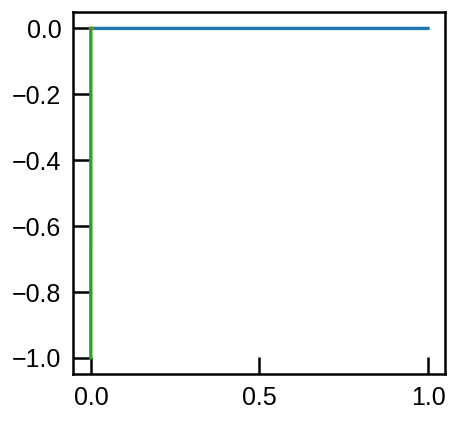

In [84]:
for i in range(3):
    plt.plot([0,v[0,i]],[0,v[1,i]]);

In [66]:
hess_zz = potential.hessian(w0_cl.xyz)[:,:,0][2,2]
np.sqrt(np.abs(hess_zz)).to(u.km/u.s/u.kpc)

<Quantity 66.84468859 km / (kpc s)>

In [19]:
H = gp.Hamiltonian(potential)
df = ms.FardalStreamDF()
gen_fardal = ms.MockStreamGenerator(df, H)

df = ms.StreaklineStreamDF()
gen_streakline = ms.MockStreamGenerator(df, H)

prog_mass = 1000* u.Msun
stream_fardal, prog = gen_fardal.run(w0_cl, prog_mass, dt=-1 * u.Myr, n_steps=500)
stream_streakline, prog = gen_streakline.run(w0_cl, prog_mass, dt=-1 * u.Myr, n_steps=1000)

In [7]:
xyz_c = np.array([17.03209335, 42.125414, 13.88740972])
vxyz_c = np.array([-6.14297276, 45.56737674, 5.50303221])

xyz = np.random.normal(xyz_c, scale=5, size=(100, 3))
vxyz_c = np.repeat(vxyz_c[None, :], 100, axis=0)

gc_coord = coord.ICRS(
    *xyz.T * u.pc,
    *vxyz_c.T * u.km / u.s,
    representation_type="cartesian",
    differential_type="cartesian"
).transform_to(gc_frame)
w0 = gd.PhaseSpacePosition(gc_coord.data)

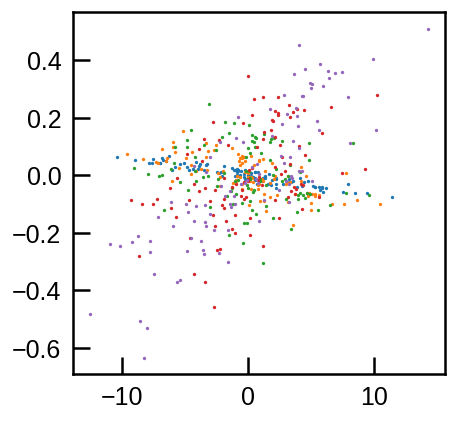

In [237]:
for n_steps in [10, 20, 30, 40, 50]:
    orbits = potential.integrate_orbit(w0, dt=1*u.Myr, n_steps=n_steps)
#     plt.figure()
    plt.scatter((orbits.y[-1]-orbits.y[-1].mean()).to(u.pc),
                (orbits.v_y[-1]-orbits.v_y[-1].mean()).to(u.km/u.s), s=1)
    # xx=np.linspace(-1,1)
    # plt.plot(xx, -67*xx)

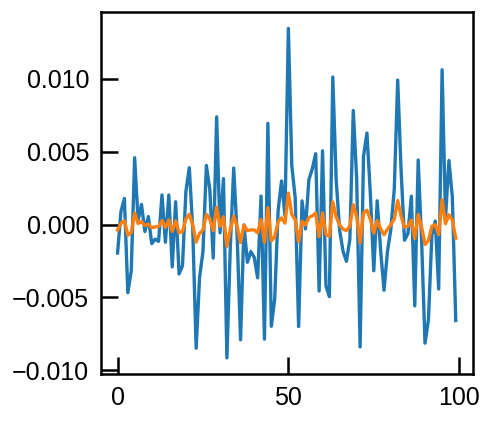

In [204]:
plt.plot(orbits.z[0] - orbits.z[0].mean())
plt.plot(orbits.z[-1] - orbits.z[-1].mean())

In [168]:
vxyz_c.shape

(100, 3)

In [15]:
prog_orbit = potential.integrate_orbit(w0_cl, dt=-1*u.Myr, n_steps=700)

In [16]:
stream_streakline_old = streakline_stream(potential, prog_orbit, 1000*u.solMass, )

NameError: name 'streakline_stream' is not defined

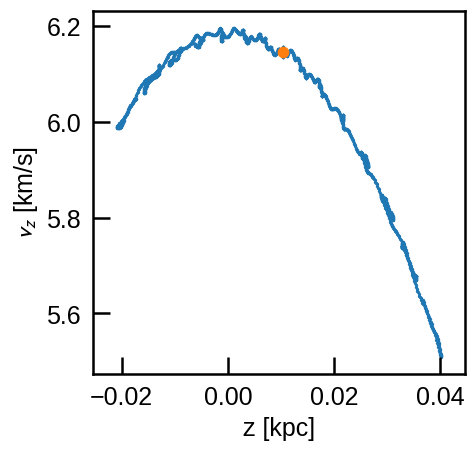

In [20]:
plt.figure(figsize=(4,4))
plt.scatter(stream_streakline.z, stream_streakline.v_z.to(u.km/u.s), s=1);
plt.scatter(prog.z, prog.v_z.to(u.km/u.s))
plt.xlabel('z [kpc]')
plt.ylabel('$v_z$ [km/s]');

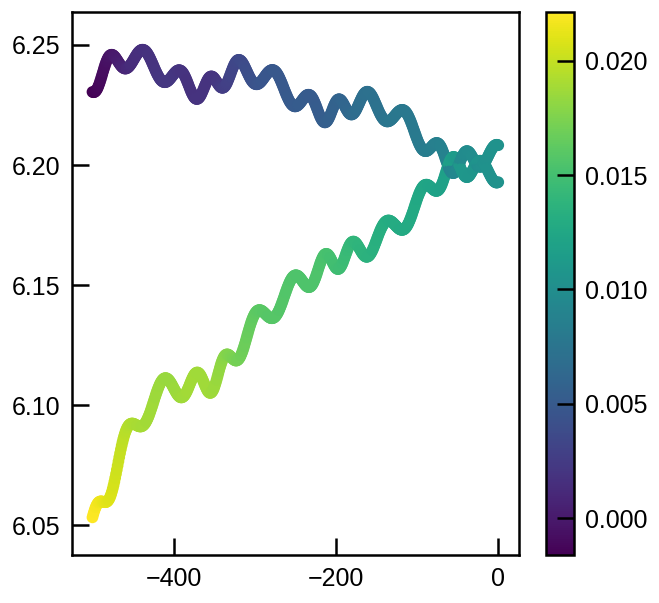

In [139]:
plt.scatter(stream_streakline.release_time, stream_streakline.v_z.to(u.km/u.s), c=stream_streakline.z)
plt.colorbar()

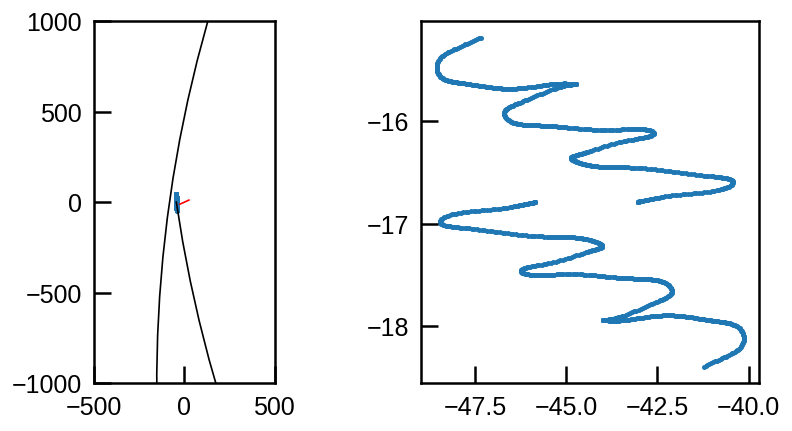

In [116]:
sgal = stream_streakline.to_coord_frame(coord.Galactic, gc_frame)
o = prog_orbit.to_coord_frame(coord.Galactic, gc_frame)
release_time = stream_streakline.release_time
x, v = sgal.cartesian, sgal.velocity

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x.x.to(u.pc), x.y.to(u.pc), s=4)
c = ax[1].scatter(x.x.to(u.pc), x.z.to(u.pc), s=4)


ax[0].plot(o.cartesian.x.to(u.pc), o.cartesian.y.to(u.pc), 'k-', lw=1)
ax[0].axis([-500,500,-1000,1000]);
ax[0].set_aspect('equal');


v_x, v_y = -42, -19
xx = np.linspace(-25,25)
ax[0].plot(xx, v_y/v_x*xx, 'r-', lw=1)
# ax[0].set_ylim(-50,150);

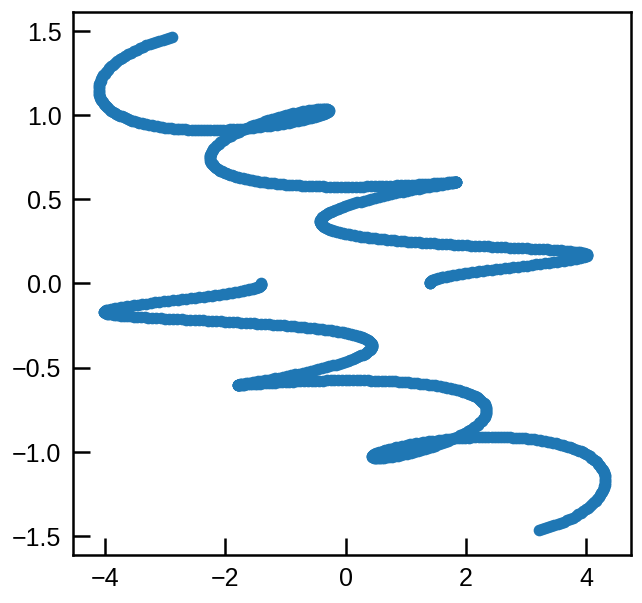

In [117]:
cl_gal = cl.transform_to(coord.Galactic)
plt.scatter((x.x - cl_gal.cartesian.x).to(u.pc), (v.d_x - cl_gal.velocity.d_x).to(u.km/u.s))

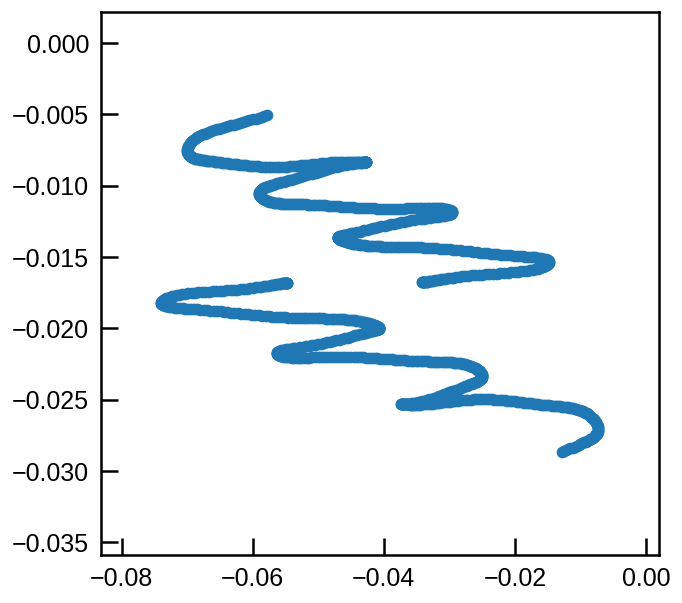

In [52]:
plt.scatter(x.x, x.z)

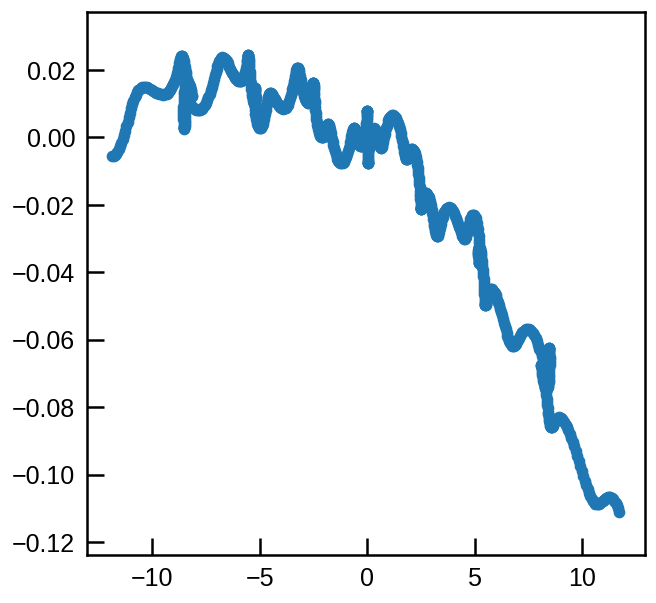

In [51]:
cl_gal = cl.transform_to(coord.Galactic)
plt.scatter((x.z - cl_gal.cartesian.z).to(u.pc), (v.d_z - cl_gal.velocity.d_z).to(u.km/u.s))

In [21]:
cl.transform_to(coord.Galactic).velocity.d_xyz

<Quantity [-42.12569553, -19.19435729,  -1.18647602] km / s>

In [22]:
w0_cl.v_xyz

<Quantity [-31.0293487 , 213.04568364,   6.20047721] km / s>

In [27]:
stream_streakline.lead_trail

array(['t', 'l', 't', ..., 'l', 't', 'l'], dtype='<U1')

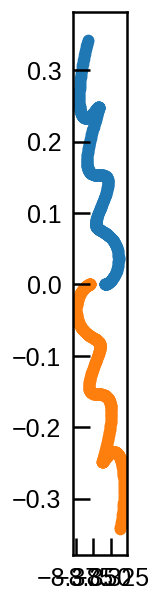

In [49]:
lead = stream_streakline.lead_trail == 'l'
plt.axes(aspect='equal')
plt.scatter(stream_streakline.x[lead], stream_streakline.y[lead], )
plt.scatter(stream_streakline.x[~lead], stream_streakline.y[~lead], )

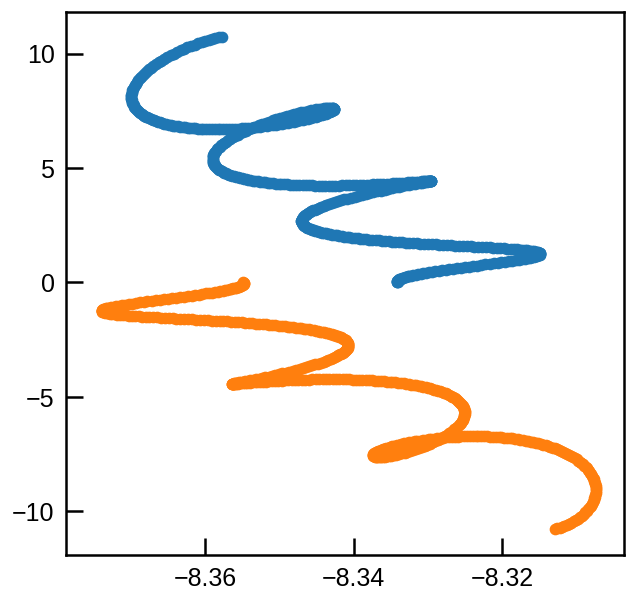

In [45]:
lead = stream_streakline.lead_trail == 'l'
# plt.axes(aspect='equal')
plt.scatter(stream_streakline.x[lead], stream_streakline.v_x[lead].to(u.km/u.s) - w0_cl.v_x)
plt.scatter(stream_streakline.x[~lead], stream_streakline.v_x[~lead].to(u.km/u.s) - w0_cl.v_x )

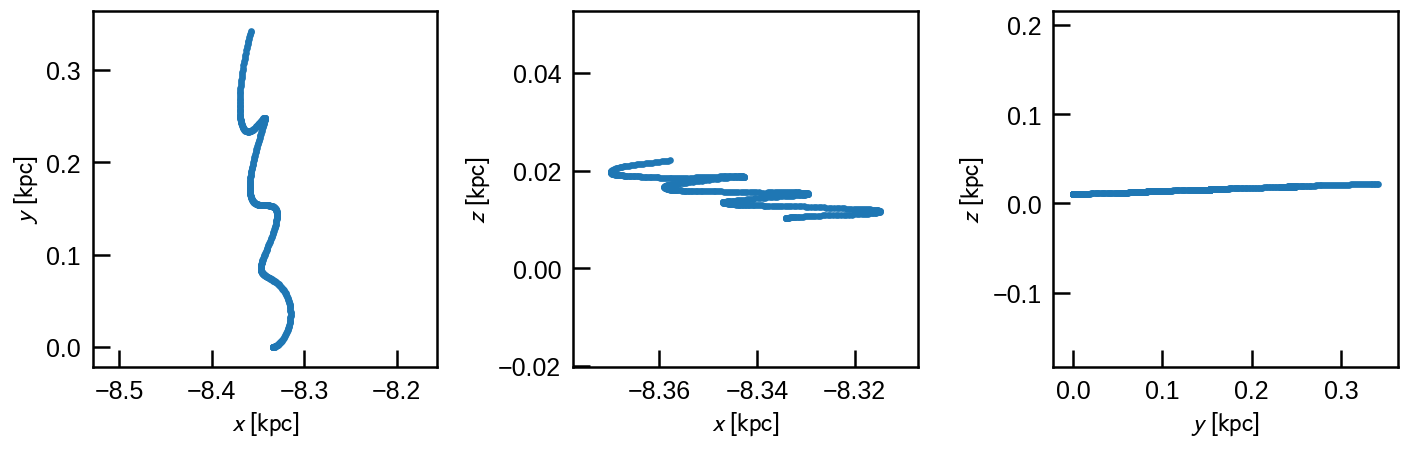

In [24]:
stream_streakline.plot();

In [55]:
stream_fardal_galactic = stream_fardal.to_coord_frame(coord.ICRS)
stream_streakline_galactic = stream_streakline.to_coord_frame(coord.ICRS)

In [47]:
hess = potential.hessian(w0_cl.xyz)[:,:,0]

In [48]:
hess[0,0], hess[1,1], hess[2,2]

(<Quantity -0.00059883 1 / Myr2>,
 <Quantity 0.00013458 1 / Myr2>,
 <Quantity 0.00467219 1 / Myr2>)

<Quantity 23.92765553 km / (kpc s)>

In [101]:
dvx

<Quantity [-8.71153184e-03,  1.84401511e-02, -1.86593718e-02, ...,
            2.34532253e-05, -3.00183798e-08,  1.49613537e-07] kpc / Myr>

In [124]:
hess_xx

<Quantity 23.92765553 km / (kpc s)>

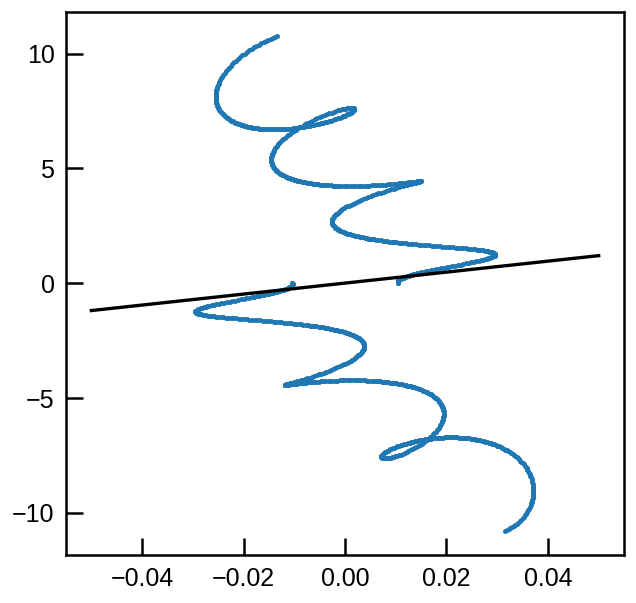

In [50]:
s = stream_streakline.to_coord_frame(coord.Galactic)
dx = s.cartesian.x - w0_cl.to_coord_frame(coord.Galactic).cartesian.x
dvx = s.velocity.d_x - w0_cl.to_coord_frame(coord.Galactic).velocity.d_x
plt.scatter(dx.to(u.kpc), dvx.to(u.km/u.s), s=4);

hess_xx = np.sqrt(np.abs(hess[0,0])).to(u.km/u.s/u.kpc)
x = np.linspace(-0.05, 0.05, 21)
plt.plot(x, hess_xx.value * x, 'k-')

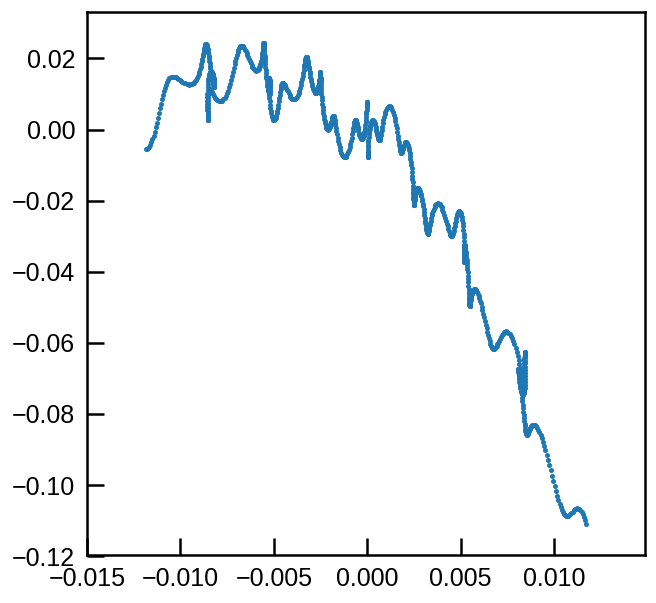

In [54]:
s = stream_streakline.to_coord_frame(coord.Galactic)
dx = s.cartesian.z - w0_cl.to_coord_frame(coord.Galactic).cartesian.z
dvx = s.velocity.d_z - w0_cl.to_coord_frame(coord.Galactic).velocity.d_z
plt.scatter(dx.to(u.kpc), dvx.to(u.km/u.s), s=4);

# hess_xx = np.sqrt(np.abs(hess[2,2])).to(u.km/u.s/u.kpc)
# x = np.linspace(-0.01, 0.01, 21)
# plt.plot(x, -hess_xx.value * x, 'k-')

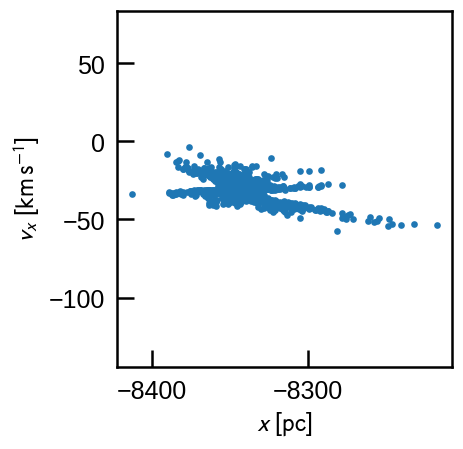

In [84]:
stream_fardal.plot(['x', 'v_x'], units=(u.pc, u.km/u.s));

In [57]:
stream_fardal_galactic = stream_fardal.to_coord_frame(coord.Galactic)
stream_streakline_galactic = stream_streakline.to_coord_frame(coord.Galactic)

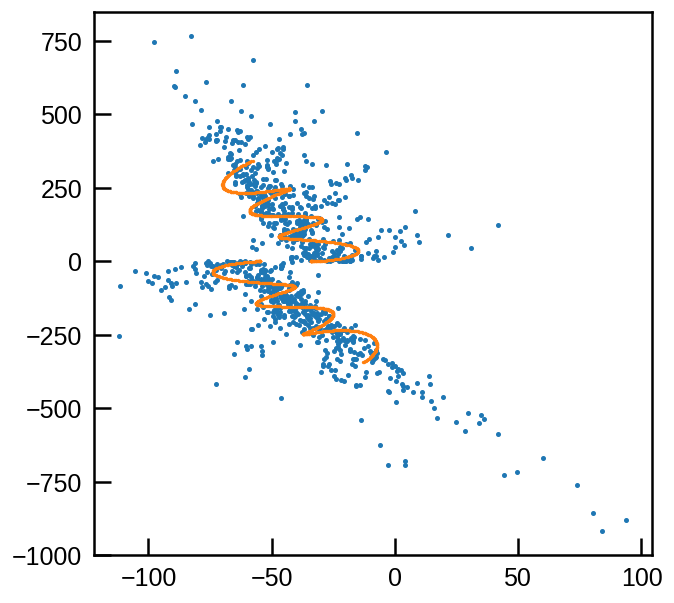

In [58]:
plt.scatter(
    stream_fardal_galactic.cartesian.x.to(u.pc),
    stream_fardal_galactic.cartesian.y.to(u.pc),
    s=4,
)
plt.scatter(
    stream_streakline_galactic.cartesian.x.to(u.pc),
    stream_streakline_galactic.cartesian.y.to(u.pc),
    s=1,
);

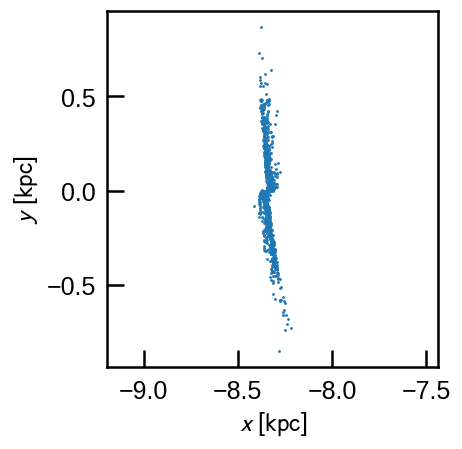

In [33]:
fig = stream_fardal.plot(['x', 'y'], s=2)


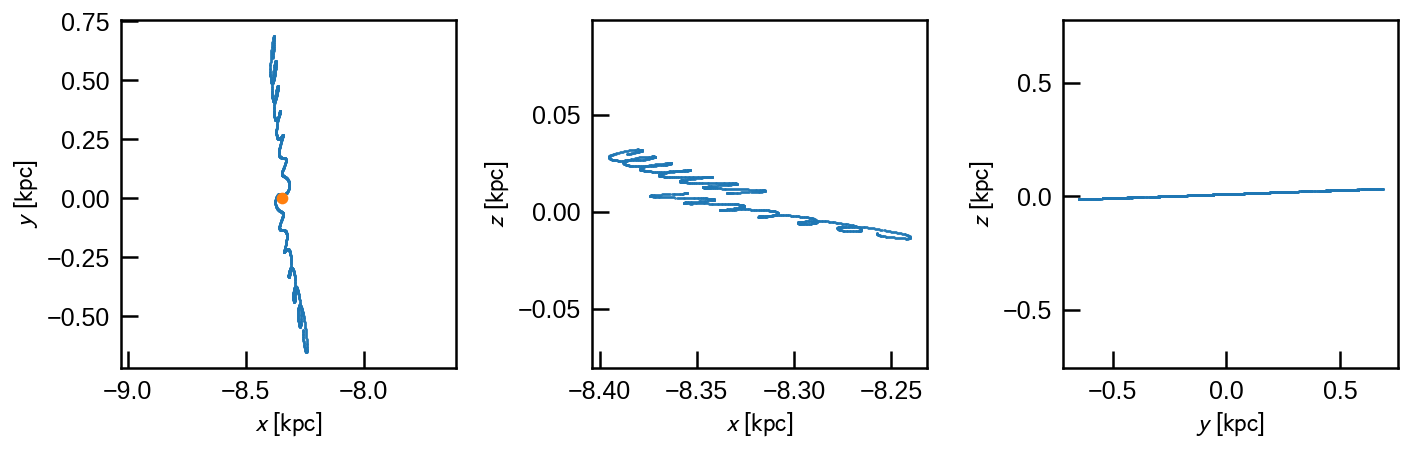

In [54]:
stream = ms.streakline_stream(potential, prog_orbit[::-1], prog_mass=400*u.Msun,
                       release_every=1)
fig = stream.plot(marker='.', s=1)
fig.axes[0].scatter(prog_orbit.x[0], prog_orbit.y[0]);

In [55]:
stream_galactic = stream.to_frame(coord.Galactic)

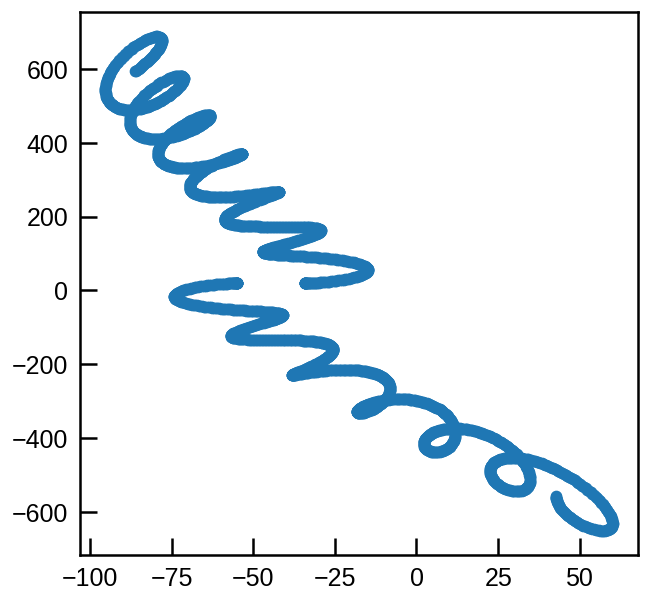

In [56]:
plt.scatter(stream_galactic.cartesian.x.to(u.pc), stream_galactic.cartesian.y.to(u.pc),);

In [ ]:
def plot_xv(coo):
    """Plot [x, y, z] x [v_x, v_y, v_z] on 3x3 grid of axes
    
    coo : coordinates instance
    """
    cartX, cartV = coo.cartesian, coo.velocity

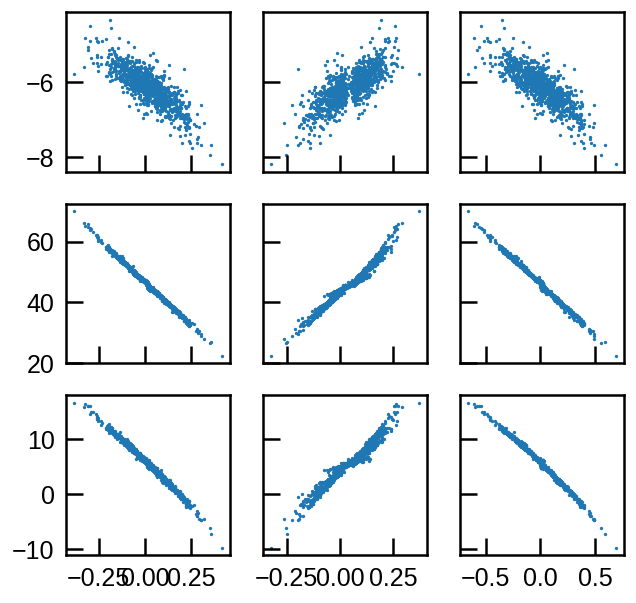

In [55]:
stream = stream_fardal.to_coord_frame(coord.ICRS)
fig, ax = plt.subplots(3, 3, figsize=(6,6), sharex='col', sharey='row')

ax[0,0].scatter(stream.cartesian.x, stream.velocity.d_x.to(u.km/u.s), s=1)
ax[1,0].scatter(stream.cartesian.x, stream.velocity.d_y.to(u.km/u.s), s=1)
ax[2,0].scatter(stream.cartesian.x, stream.velocity.d_z.to(u.km/u.s), s=1)

ax[0,1].scatter(stream.cartesian.y, stream.velocity.d_x.to(u.km/u.s), s=1)
ax[1,1].scatter(stream.cartesian.y, stream.velocity.d_y.to(u.km/u.s), s=1)
ax[2,1].scatter(stream.cartesian.y, stream.velocity.d_z.to(u.km/u.s), s=1)

ax[0,2].scatter(stream.cartesian.z, stream.velocity.d_x.to(u.km/u.s), s=1)
ax[1,2].scatter(stream.cartesian.z, stream.velocity.d_y.to(u.km/u.s), s=1)
ax[2,2].scatter(stream.cartesian.z, stream.velocity.d_z.to(u.km/u.s), s=1);

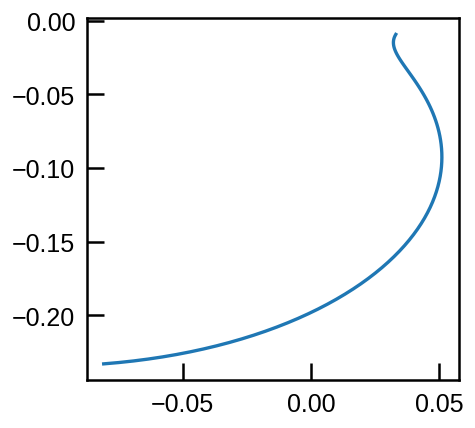

In [28]:
p1 = potential.integrate_orbit(stream[2], dt=-1*u.Myr, n_steps=100)
plt.plot(p1.x-sun_orbit.x, p1.y-sun_orbit.y)

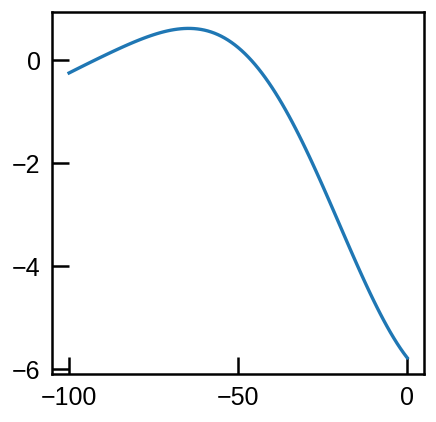

In [29]:
plt.plot(p1.t, (p1.v_x-sun_orbit.v_x).to(u.km/u.s))

In [98]:
!rm -f mockstream

In [99]:
from gala.dynamics.mockstream import fardal_stream
stream = fardal_stream(potential, sun_orbit[::-1], prog_mass=1e3*u.Msun,
                       release_every=1, snapshot_filename='mockstream', output_every=5)

In [90]:
import h5py

In [100]:
f = h5py.File("mockstream")
f.keys()

<KeysViewHDF5 ['pos', 't', 'vel']>

In [101]:
f['pos'].shape, f['t'].shape, f['vel'].shape

((3, 22, 202), (101,), (3, 22, 202))

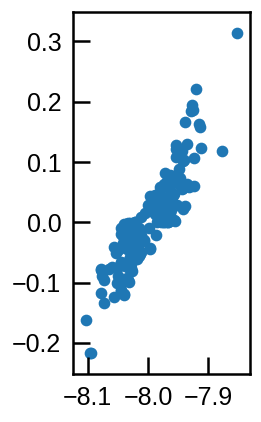

In [81]:
ax = plt.axes(aspect='equal')
ax.scatter(stream.x, stream.y)

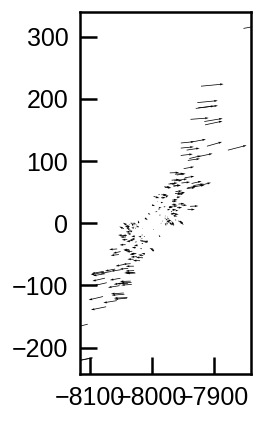

In [82]:
ax = plt.axes(aspect='equal')
ax.quiver(stream.x.to(u.pc), stream.y.to(u.pc), stream.v_x.to(u.km/u.s).value, (stream.v_y-vcirc[0]).to(u.km/u.s).value);

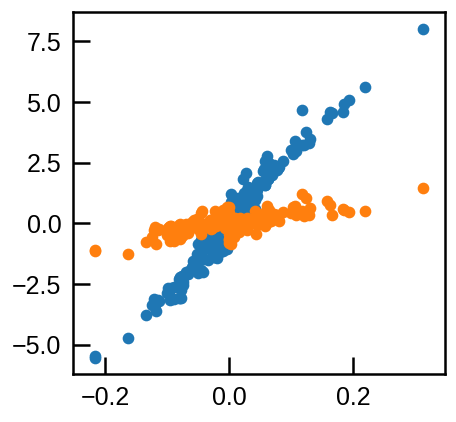

In [83]:
plt.scatter(stream.y, stream.v_x.to(u.km/u.s))
plt.scatter(stream.y, stream.v_y.to(u.km/u.s)-vcirc[0])

In [14]:
vcirc = potential.circular_velocity([8,0,0]*u.kpc)
print(vcirc)

[231.76143311] km / s


In [22]:
N = 10
vel = np.zeros((3, N))
vel[1] = 231.76
vel[2] = np.linspace(-1, 1, N)

In [29]:
pos = np.zeros((3, N))
pos[0] = -8

In [33]:
w0 = gd.PhaseSpacePosition(pos*u.kpc, vel*u.km/u.s)
orbit = potential.integrate_orbit(w0, dt=1*u.Myr, n_steps=10)


In [40]:
orbit.x[-1]

<Quantity [-7.6514066 , -7.65140631, -7.65140609, -7.65140595, -7.65140587,
           -7.65140587, -7.65140595, -7.65140609, -7.65140631, -7.6514066 ] kpc>

In [44]:
(orbit.x[-5]-orbit.x[0]).to(u.pc)

<Quantity [126.08358427, 126.08362346, 126.08365286, 126.08367246,
           126.08368226, 126.08368226, 126.08367246, 126.08365286,
           126.08362346, 126.08358427] pc>

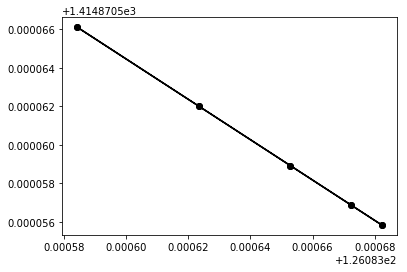

In [43]:
plt.plot((orbit.x[-5]-orbit.x[0]).to(u.pc),
         (orbit.y[-5]-orbit.y[0]).to(u.pc), 'ko-')